# Visualising micromagnetic simulation data with Holoviews

In micromagnetic simulations, it is common to want to investigate systems through a multidimensional parameter space. We may wish to see how a system evolves through time, or how adjusting the strength of interactions might change the final state. In this notebook, we show how output files from OOMMF can be displayed using Holoviews, and how this can allow interactive exploration of data.

In [1]:
import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import holoviews as hv
import pandas as pd
import numpy as np
import oommffield
import os
import glob
import re
datafiles = os.path.join(os.getcwd(), 'data')
hv.notebook_extension('matplotlib')


Here, we define a function which takes either a string, which is the path to an OOMMF magnetisation vector (OMF) file, or a Field object from the module oommffield. This constructs a Holoviews object which is the sum of two parts:
* A hv.VectorField object - this shows a plot of the in-plane magnetisation
* a hv.Image object - this shows a plot of the out-of-plane magnetisation

In [6]:
def field2inplane(field, slice_axis, slice_coord):
    """
    field2hv(field, slice_axis, slice_coord)
    
    This function constructs a Holoviews object
    which shows the in plane Magnetisation and out of plane Magnetisation
    
    Inputs
    ======
    field:
        Path to an OMF file or object of type oommffield.Field
    slice_axis:
        The axis along which the vector field will be sliced given as a string.
        Must be one of ['x', 'y', 'z']
    slice_coord:
        The coordinate along the slice_axis where the field is sliced
    """
    # Construct a field object if not a field object
    if isinstance(field, str):
        field = oommffield.read_oommf_file(field)
    field.normalise()
    if slice_axis == 'z':
        axis = (0, 1, 2)
    elif slice_axis == 'y':
        axis = (0, 2, 1)
    elif slice_axis == 'x':
        axis = (1, 2, 0)
    else:
        raise ValueError("Slice Axis must be one of 'x', 'y' ,'z'")
    dims = ['x', 'y', 'z']
    bounds = [field.cmin[axis[0]], field.cmin[axis[1]], field.cmax[axis[0]], field.cmax[axis[1]]]
    x, y, vec, coords = field.slice_field(slice_axis, slice_coord)
    X, Y = np.meshgrid(x, y)
    flat = vec.flatten()
    modm = (flat[axis[0]::3]**2 + flat[axis[1]::3]**2).reshape((len(x), len(y)))
    angm = np.arctan2(flat[axis[1]::3], flat[axis[0]::3]).reshape((len(x), len(y)))
    outofplane = flat[axis[2]::3]
    mz = flat[axis[2]::3].reshape((len(x), len(y)))
    kdims = kdims=[dims[axis[0]], dims[axis[1]]]
    return hv.VectorField([X, Y, angm, modm],
                          kdims = kdims, vdims=['xyfield'],
                          label='In-plane Magnetisation')

In [7]:
def field2outofplane(field, slice_axis, slice_coord):
    """
    field2hv(field, slice_axis, slice_coord)
    
    This function constructs a Holoviews object
    which shows the in plane Magnetisation and out of plane Magnetisation
    
    Inputs
    ======
    field:
        Path to an OMF file or object of type oommffield.Field
    slice_axis:
        The axis along which the vector field will be sliced given as a string.
        Must be one of ['x', 'y', 'z']
    slice_coord:
        The coordinate along the slice_axis where the field is sliced
    """
    # Construct a field object if not a field object
    if isinstance(field, str):
        field = oommffield.read_oommf_file(field)
    field.normalise()
    if slice_axis == 'z':
        axis = (0, 1, 2)
    elif slice_axis == 'y':
        axis = (0, 2, 1)
    elif slice_axis == 'x':
        axis = (1, 2, 0)
    else:
        raise ValueError("Slice Axis must be one of 'x', 'y' ,'z'")
    dims = ['x', 'y', 'z']
    bounds = [field.cmin[axis[0]], field.cmin[axis[1]], field.cmax[axis[0]], field.cmax[axis[1]]]
    x, y, vec, coords = field.slice_field(slice_axis, slice_coord)
    X, Y = np.meshgrid(x, y)
    flat = vec.flatten()
    modm = (flat[axis[0]::3]**2 + flat[axis[1]::3]**2).reshape((len(x), len(y)))
    angm = np.arctan2(flat[axis[1]::3], flat[axis[0]::3]).reshape((len(x), len(y)))
    outofplane = flat[axis[2]::3]
    mz = flat[axis[2]::3].reshape((len(x), len(y)))
    kdims = kdims=[dims[axis[0]], dims[axis[1]]]
    return hv.Image(mz, bounds=bounds,
                    label='Out of plane Magnetisation',
                    kdims = kdims, 
                    vdims=[hv.Dimension('M{}'.format(slice_axis),
                                        range=(-1, 1))])

We can load up an OMF file from an OOMMF simulation of a cube of dimensions [5e-8, 5e-8, 5e-8] nm to test this works. Here, the simulation files correspond to the output from a hysteresis simulation of a cube, with Exchange and Demagnetisation interactions included.

In [8]:
# Glob through data file directory for *.omf files.
files = sorted(glob.glob(datafiles + '/*.omf'))
# Get holoviews object from the first file
test = field2outofplane(files[0], 'y', 0e-8)

b':Image   [x,z]   (My)'
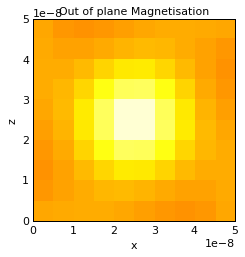

In [9]:
test

We can sample across a holoviews Image element through the centre of the image:

:Layout
   .Image.Out_of_plane_Magnetisation :Image   [x,z]   (My)
   .Curve.I                          :Curve   [x]   (My)
   .Curve.II                         :Curve   [x]   (My)
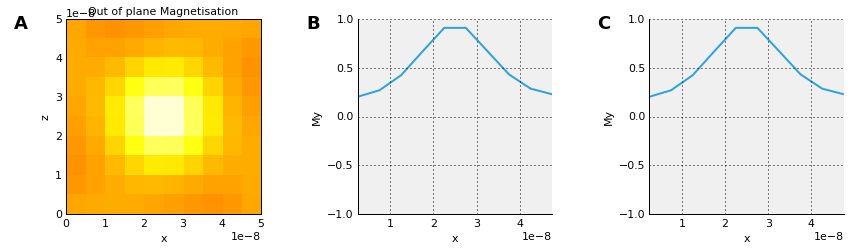

In [10]:
test + test.sample(z = 2.5e-8) + test.sample(z = 2.5e-8)

We might want to change the colourmap of the B image to a divergent colourmap, and add a colorbar. We can do this by setting properties of the renderer with cell magics:


b':Image   [x,z]   (My)'
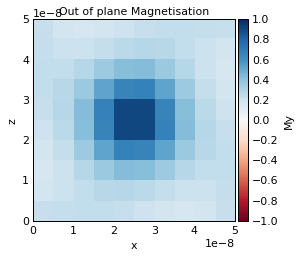

In [11]:
%%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]
test

We have several dimensions through which to explore the data - the files correspond to different simulation parameters (in this case, the applied field), and we may want to look at how the magnetisation varies along each of the axes. To explore the data, we create a Holomap, which will provide sliders and selectors which allow the varying of how we visualise the simulation data.

The first step to this is to construct dimensions for which we want to explore the data.

In [12]:
physical_dimension = hv.Dimension("SliceDimension")
file = hv.Dimension('File')
slice_dimension = hv.Dimension('Coordinates')

dims = ['x', 'y', 'z', None] # None is there due to a bug in Holoviews 1.6.1 - 
                             # https://github.com/ioam/holoviews/pull/830
slicecoords = np.linspace(0, 5e-8, 11)
slicecoords = list(slicecoords)
slicecoords.append(None)

We now construct the holoviews objects for each combination across parameter space, by creating a list of tuples of the form. We process the filenames with a function to something more reasonable.
> ((parameter arguments), output)

In [13]:
filename_fun = lambda filename: int(filename.split('-')[3])

In [14]:
mapdata = [((filename_fun(file), slicedim, slicecoord), 
           field2inplane(file, slicedim, slicecoord) + field2outofplane(file, slicedim, slicecoord)) 
           for file in files 
           for slicedim in ['x', 'y', 'z'] 
           for slicecoord in slicecoords]

TypeError: unorderable types: float() <= NoneType()

We can now create a holomap of this data, which allows us to explore the datafiles:

In [15]:
holomap = hv.HoloMap(mapdata, kdims=[file, physical_dimension, slice_dimension])

NameError: name 'mapdata' is not defined

We can then render the HoloMap by accessing it. It is worth noting that for large amounts of data this can take some time, and DynamicMap, which renders on the fly rather than all at once, is more suitable. On the other hand, once a HoloMap has been created, you can embed the notebook into webpages or reload the notebook for interactive visualisation without having to run the notebook.

The cell below takes a long time to run - skip ahead to the DynamicMap if you're not running on a powerful computer.

In [16]:
%%output max_frames=5000 
%%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]
holomap

NameError: name 'holomap' is not defined

Clearly there is a lot of potential. Examples of other parameters you could explore are:
* Time
* System size
* Applied Field
* Exchange/DMI/Anisotropy strength
* Anisotropy Axis

Additionally, other hv objects can be created which can be computed for each slice through the field:
* Field profile along an axis
* Skyrmion number
* Structure factor

Here, we use the same data to create a Dynamic Map - to see this, a live notebook server must be used.

In [ ]:
# Here we set the value ranges for the dimensions defined earlier. This 
physical_dimension.values = ['x', 'y', 'z', None]
file.values = files
file.value_format = filename_fun
slice_dimension.values = list(slicecoords)
slice_dimension.values.append(None)

In [ ]:
dmap = hv.DynamicMap(field2outofplane, kdims=[file, physical_dimension, slice_dimension])

In [ ]:
%%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]
dmap

In [ ]:
dmap_inplane = hv.DynamicMap(field2inplane, kdims=[file, physical_dimension, slice_dimension])

In [ ]:
dmap_inplane

In [ ]:
dmap + dmap_inplane 

In [ ]:
import pandas as pd

In [ ]:
import oommfodt

In [ ]:
odtpath = os.path.join(datafiles, 'cube_example.odt')

In [ ]:
odtdata = oommfodt.OOMMFodt(odtpath)

In [ ]:
def odt2df_fromfiles(files, odtfile):
    """
    odt2df_fromfiles(files)
    
    Takes a list of omf filenames and selects rows in ODT file which correspond
    to these files
    
    Inputs
    ------
    files - List of omf file paths
    odtfile - path to OOMMF ODT file. This file must have the columns
        'stage' and 'iteration' as headers, as these are used
        to match up the data. Additionally, OOMMF omf file names must
        not have been modified from their original format.
    """
    strarray = [re.findall(r"[\w']+", file)[10:12] for file in files]
    relevantfiles = np.array([[int(i[0]), int(i[1])] for i in strarray])
    index = pd.DataFrame(relevantfiles, columns = ('stage', 'iteration'))
    
    odtframe = oommfodt.OOMMFodt(odtfile).df
    reduced = pd.merge(index, odtframe)
    reduced = reduced.reset_index()
    return reduced

In [ ]:
a = odt2df_fromfiles(files, odtpath)

In [ ]:
class hvODT:
    def __init__(self, odtpath, omfpaths):
        self.omfpaths = omfpaths
        strarray = [re.findall(r"[\w']+", file)[10:12] for file in omfpaths]
        relevantfiles = np.array([[int(i[0]), int(i[1])] for i in strarray])
        index = pd.DataFrame(relevantfiles, columns = ('stage', 'iteration'))

        odtframe = oommfodt.OOMMFodt(odtpath).df
        reduced = pd.merge(index, odtframe)
        reduced = reduced.reset_index()
        reduced.rename(columns={'index':'File'}, inplace=True)
        self.frame = reduced
        self.headers = list(reduced.columns)[1:]
        self.hv = hv.Table(self.frame)
    def get_curve(self, file, graph):
        if isinstance(file, str):
            try:
                index = self.omfpaths.index(file)
            except:
                raise ValueError("File not in list of OMF files")
        else:
            index = file
        return self.hv.to.curve('File', graph, []) * \
               hv.VLine(index) 

            
odttest = hvODT(odtpath, files)

In [ ]:
odttest.headers.append(None)

In [ ]:
graphs = hv.Dimension('Graph', values=odttest.headers)

In [ ]:
dmap_curves = hv.DynamicMap(odttest.get_curve, kdims=[file, graphs])


In [ ]:
kdims

In [ ]:
dmap_curves

In [ ]:
dmap + dmap_inplane + dmap_curves

In [ ]:
dmap_curves

In [ ]:
hv.__version__

In [ ]:
renderer = hv.Store.renderers['matplotlib']

In [ ]:
import holoviews as hv
import numpy as np
hv.notebook_extension('matplotlib')
kdims = [file,
         hv.Dimension('SliceDimension', values=['x', 'y', 'z']),
         hv.Dimension('Coordinates', range=(0.01, 1))]
dmap1 = hv.DynamicMap(lambda x, y, z: hv.Image(np.random.rand(10,10)), kdims=kdims)
dmap2 = hv.DynamicMap(lambda x: hv.Curve(np.random.rand(10,2))*hv.VLine(x),
                     kdims=kdims[:1])
